In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
#importing new slides
import pandas as pd 
import requests 
from bs4 import BeautifulSoup 
import time 
import random 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
import geopandas as gp
import folium
import mapclassify
from pandas import DataFrame

# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

#### Methodology 
- Clean and aggregate multiple different CVS and shapefiles to create a master data set 
- Geospatially viualize this data to understand relevant trends
- Run this data through the ML pipeline and indentify most accurate models 



#### Tools and models 
- Pandas, Numpy, Geopandas, matplotlib, Sklearn 
- Naive Bayes, Decision Tree, K nearest neighbors, Random Forest

#### Data 
- The Vera Insititue GitHub data on incarcerated individuals by county 
- Department of Agriculture Eduction data, Economic data, General demographic data 
- EPA county level pollution data


 

####  Additional/Future Considerations 
- Geopandas advanced geospatial machine learning tools
 - Geopspatial regressions and geospatial clustering 
- Incorporating a time series aspect to my analysis 
    - Currently I am only focusing on 2018 but would like to expand this
- Creating new interaction variables and predictive metrics based on preliminary findings
- Adding additional variables to my model based on my findings and relevant literature

    



#### Potential Additional Sources 
- County categorizations based on social science literautre
- County and state voting paterns
- County investment in police budgets

In [3]:
#loading in data 
countyshp=('/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/USA_Counties/USA_Counties.shp')
countyshp=gp.read_file(countyshp)

incpath="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/incarceration_trends.csv"
incdat = pd.io.parsers.read_csv(incpath, dtype={'fips': 'str'})
incdat2018=incdat.query("year == 2018")

unemployment="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/Unepmloyment_Dat.csv"
unemploymentdat=pd.io.parsers.read_csv(unemployment, dtype={'FIPS_Code': 'str'})

poverty="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/Poverty_dat.csv"
povertydat=pd.io.parsers.read_csv(poverty, dtype={'FIPStxt': 'str'})

envpath="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/ctyfactbook2020 (2).csv"
envpathdat=pd.io.parsers.read_csv(envpath, dtype={'County FIPS Code': 'str'})

edcat="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/Education_by_County.csv"
eddat=pd.io.parsers.read_csv(edcat, dtype={'FIPS Code': 'str'})

#reading in policts
votedat = pd.read_csv("/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/countypres_2000-2020.tab",sep='\t',header=(0), 
dtype={'county_fips': 'str'} )

polpath="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/Poldat.csv"
policedat=pd.io.parsers.read_csv(polpath, dtype={'FIPS': 'str'})

#reading in policts
demdat="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/cc-est2019-alldata.csv"
demdat=pd.io.parsers.read_csv(demdat, dtype={'STATE': 'str', 'COUNTY': 'str'})

#reading in policts
rural="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/ruralurbancodes2013.csv"
ruraldat=pd.io.parsers.read_csv(rural, dtype={'FIPS': 'str'})

In [4]:
pd.set_option('display.max_columns', None)
display(eddat[:5])
display(povertydat[:5])
display(unemploymentdat[:5])
display(incdat[:5])
display(votedat[:5])
display(demdat[:5])
display(ruraldat[:5])

,FIPS Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970","Four years of college or higher, 1970","Percent of adults with less than a high school diploma, 1970","Percent of adults with a high school diploma only, 1970","Percent of adults completing some college (1-3 years), 1970","Percent of adults completing four years of college or higher, 1970","Less than a high school diploma, 1980","High school diploma only, 1980","Some college (1-3 years), 1980","Four years of college or higher, 1980","Percent of adults with less than a high school diploma, 1980","Percent of adults with a high school diploma only, 1980","Percent of adults completing some college (1-3 years), 1980","Percent of adults completing four years of college or higher, 1980","Less than a high school diploma, 1990","High school diploma only, 1990","Some college or associate's degree, 1990","Bachelor's degree or higher, 1990","Percent of adults with less than a high school diploma, 1990","Percent of adults with a high school diploma only, 1990","Percent of adults completing some college or associate's degree, 1990","Percent of adults with a bachelor's degree or higher, 1990","Less than a high school diploma, 2000","High school diploma only, 2000","Some college or associate's degree, 2000","Bachelor's degree or higher, 2000","Percent of adults with less than a high school diploma, 2000","Percent of adults with a high school diploma only, 2000","Percent of adults completing some college or associate's degree, 2000","Percent of adults with a bachelor's degree or higher, 2000","Less than a high school diploma, 2015-19","High school diploma only, 2015-19","Some college or associate's degree, 2015-19","Bachelor's degree or higher, 2015-19","Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19"
0,01000,AL,Alabama,NaN,NaN,NaN,NaN,"1,062,306","468,269","136,287","141,936",58.7,25.9,7.5,7.8,"964,840","704,207","278,205","270,063",43.5,31.8,12.5,12.2,"843,638","749,591","553,512","399,228",33.1,29.4,21.7,15.7,"714,081","877,216","746,495","549,608",24.7,30.4,25.9,19.0,"458,922","1,022,839","993,344","845,772",13.8,30.8,29.9,25.5
1,01001,AL,Autauga County,2.0,2.0,2.0,2.0,"6,611","3,757",933,767,54.8,31.1,7.7,6.4,"7,074","6,145","2,104","2,117",40.6,35.2,12.1,12.1,"6,252","6,671","4,912","3,026",30.0,32.0,23.5,14.5,"5,872","9,332","7,413","4,972",21.3,33.8,26.9,18.0,"4,291","12,551","10,596","9,929",11.5,33.6,28.4,26.6
2,01003,AL,Baldwin County,4.0,5.0,3.0,2.0,"18,726","8,426","2,334","2,038",59.4,26.7,7.4,6.5,"18,125","15,380","6,602","5,498",39.7,33.7,14.5,12.1,"17,309","20,544","15,900","10,870",26.8,31.8,24.6,16.8,"17,258","28,428","28,178","22,146",18.0,29.6,29.3,23.1,"13,893","41,797","47,274","48,148",9.2,27.7,31.3,31.9
3,01005,AL,Barbour County,6.0,6.0,6.0,6.0,"8,120","2,242",581,861,68.8,19.0,4.9,7.3,"7,759","3,671","1,362","1,300",55.1,26.1,9.7,9.2,"6,965","4,258","2,622","1,857",44.4,27.1,16.7,11.8,"6,679","6,124","4,025","2,068",35.3,32.4,21.3,10.9,"4,812","6,396","4,676","2,080",26.8,35.6,26.0,11.6
4,01007,AL,Bibb County,1.0,1.0,1.0,1.0,"5,272","1,402",238,302,73.1,19.4,3.3,4.2,"5,254","2,611",536,433,59.5,29.6,6.1,4.9,"4,850","3,407","1,332",476,48.2,33.8,13.2,4.7,"4,984","4,838","2,756",962,36.8,35.7,20.4,7.1,"3,386","7,256","3,848","1,678",20.9,44.9,23.8,10.4


,FIPStxt,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_2013,POVALL_2019,CI90LBALL_2019,CI90UBALL_2019,PCTPOVALL_2019,CI90LBALLP_2019,CI90UBALLP_2019,POV017_2019,CI90LB017_2019,CI90UB017_2019,PCTPOV017_2019,CI90LB017P_2019,CI90UB017P_2019,POV517_2019,CI90LB517_2019,CI90UB517_2019,PCTPOV517_2019,CI90LB517P_2019,CI90UB517P_2019,MEDHHINC_2019,CI90LBINC_2019,CI90UBINC_2019,POV04_2019,CI90LB04_2019,CI90UB04_2019,PCTPOV04_2019,CI90LB04P_2019,CI90UB04P_2019
0,00000,US,United States,NaN,NaN,NaN,NaN,"39,490,096","39,248,096","39,732,096",12.3,12.2,12.4,"12,000,470","11,865,995","12,134,945",16.8,16.6,17.0,"8,258,906","8,160,650","8,357,162",15.8,15.6,16.0,"65,712","65,594","65,830","3,457,689","3,405,854","3,509,524",18.2,17.9,18.5
1,01000,AL,Alabama,NaN,NaN,NaN,NaN,"747,478","730,491","764,465",15.6,15.2,16.0,"233,890","225,712","242,068",21.9,21.1,22.7,"161,670","154,564","168,776",20.7,19.8,21.6,"51,771","51,179","52,363","69,236","65,296","73,176",24.2,22.8,25.6
2,01001,AL,Autauga County,2.0,2.0,2.0,2.0,"6,723","5,517","7,929",12.1,9.9,14.3,"2,040","1,472","2,608",15.9,11.5,20.3,"1,376",902,"1,850",14.4,9.4,19.4,"58,233","52,517","63,949",NaN,NaN,NaN,NaN,NaN,NaN
3,01003,AL,Baldwin County,4.0,5.0,3.0,2.0,"22,360","18,541","26,179",10.1,8.4,11.8,"6,323","4,521","8,125",13.5,9.6,17.4,"4,641","3,295","5,987",13.3,9.4,17.2,"59,871","54,593","65,149",NaN,NaN,NaN,NaN,NaN,NaN
4,01005,AL,Barbour County,6.0,6.0,6.0,6.0,"5,909","4,787","7,031",27.1,22.0,32.2,"2,050","1,560","2,540",41.0,31.2,50.8,"1,468","1,114","1,822",39.5,30.0,49.0,"35,972","31,822","40,122",NaN,NaN,NaN,NaN,NaN,NaN


,FIPS_Code,State,Area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,Civilian_labor_force_2001,Employed_2001,Unemployed_2001,Unemployment_rate_2001,Civilian_labor_force_2002,Employed_2002,Unemployed_2002,Unemployment_rate_2002,Civilian_labor_force_2003,Employed_2003,Unemployed_2003,Unemployment_rate_2003,Civilian_labor_force_2004,Employed_2004,Unemployed_2004,Unemployment_rate_2004,Civilian_labor_force_2005,Employed_2005,Unemployed_2005,Unemployment_rate_2005,Civilian_labor_force_2006,Employed_2006,Unemployed_2006,Unemployment_rate_2006,Civilian_labor_force_2007,Employed_2007,Unemployed_2007,Unemployment_rate_2007,Civilian_labor_force_2008,Employed_2008,Unemployed_2008,Unemployment_rate_2008,Civilian_labor_force_2009,Employed_2009,Unemployed_2009,Unemployment_rate_2009,Civilian_labor_force_2010,Employed_2010,Unemployed_2010,Unemployment_rate_2010,Civilian_labor_force_2011,Employed_2011,Unemployed_2011,Unemployment_rate_2011,Civilian_labor_force_2012,Employed_2012,Unemployed_2012,Unemployment_rate_2012,Civilian_labor_force_2013,Employed_2013,Unemployed_2013,Unemployment_rate_2013,Civilian_labor_force_2014,Employed_2014,Unemployed_2014,Unemployment_rate_2014,Civilian_labor_force_2015,Employed_2015,Unemployed_2015,Unemployment_rate_2015,Civilian_labor_force_2016,Employed_2016,Unemployed_2016,Unemployment_rate_2016,Civilian_labor_force_2017,Employed_2017,Unemployed_2017,Unemployment_rate_2017,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019
0,00000,US,United States,NaN,NaN,NaN,"142,601,576","136,904,853","5,696,723",4.0,"143,786,537","136,977,996","6,808,541",4.7,"144,839,298","136,455,783","8,383,515",5.8,"145,660,094","136,944,522","8,715,572",6.0,"146,724,795","138,613,904","8,110,891",5.5,"148,597,241","141,000,912","7,596,329",5.1,"150,707,773","143,729,350","6,978,423",4.6,"152,191,050","145,156,133","7,034,917",4.6,"153,761,037","144,860,349","8,900,688",5.8,"153,825,454","139,594,699","14,230,755",9.3,"154,254,521","139,393,814","14,860,707",9.6,"154,520,678","140,688,861","13,831,817",9.0,"155,038,121","142,527,201","12,510,920",8.1,"155,362,278","143,905,037","11,457,241",7.4,"155,936,159","146,318,952","9,617,207",6.2,"156,840,649","148,554,918","8,285,731",5.3,"158,674,951","150,949,349","7,725,602",4.9,"160,214,378","153,237,150","6,977,228",4.4,"161,441,134","155,152,550","6,288,584",3.9,"163,140,305","157,154,185","5,986,120",3.7,"160,611,064","147,677,360","12,933,704",8.1,65712.0,NaN
1,01000,AL,Alabama,NaN,NaN,NaN,"2,147,173","2,047,731","99,442",4.6,"2,128,027","2,017,467","110,560",5.2,"2,112,621","1,987,633","124,988",5.9,"2,128,668","2,001,568","127,100",6.0,"2,138,306","2,018,783","119,523",5.6,"2,140,356","2,045,234","95,122",4.4,"2,170,007","2,083,207","86,800",4.0,"2,180,448","2,092,030","88,418",4.1,"2,176,854","2,049,579","127,275",5.8,"2,156,593","1,938,784","217,809",10.1,"2,197,028","1,968,824","228,204",10.4,"2,202,337","1,991,379","210,958",9.6,"2,178,508","2,000,848","177,660",8.2,"2,172,102","2,012,828","159,274",7.3,"2,164,715","2,018,705","146,010",6.7,"2,152,295","2,020,443","131,852",6.1,"2,155,729","2,029,157","126,572",5.9,"2,172,455","2,073,396","99,059",4.6,"2,207,019","2,120,704","86,315",3.9,"2,237,278","2,169,395","67,883",3.0,"2,230,118","2,099,062","131,056",5.9,51771.0,100.0
2,01001,AL,"Autauga County, AL",2.0,2.0,1.0,"21,861","20,971",890,4.1,"22,081","21,166",915,4.1,"22,161","21,096","1,065",4.8,"22,695","21,557","1,138",5.0,"23,241","22,146","1,095",4.7,"23,887","22,986",901,3.8,"24,425","23,619",806,3.3,"24,434","23,610",824,3.4,"24,687","23,376","1,311",5.3,"24,660","22,464","2,196",8.9,"25,749","23,481","2,268",8.8,"25

,yfips,year,fips,state,county_name,total_pop,total_pop_15to64,female_pop_15to64,male_pop_15to64,aapi_pop_15to64,black_pop_15to64,latinx_pop_15to64,native_pop_15to64,white_pop_15to64,urbanicity,region,division,commuting_zone,metro_area,land_area,total_jail_pop,female_jail_pop,male_jail_pop,female_adult_jail_pop,female_juvenile_jail_pop,male_adult_jail_pop,male_juvenile_jail_pop,aapi_jail_pop,black_jail_pop,latinx_jail_pop,native_jail_pop,white_jail_pop,other_race_jail_pop,total_jail_pretrial,total_jail_from_prison,total_jail_from_other_jail,total_jail_from_fed,total_jail_from_bia,total_jail_from_bop,total_jail_from_ice,total_jail_from_marshals,total_jail_from_other_fed,jail_rated_capacity,private_jail_flag,regional_jail_flag,total_jail_adm,total_jail_dis,total_jail_pop_dcrp,female_jail_pop_dcrp,male_jail_pop_dcrp,total_jail_adm_dcrp,female_jail_adm_dcrp,male_jail_adm_dcrp,total_prison_pop,female_prison_pop,male_prison_pop,aapi_prison_pop,black_prison_pop,latinx_prison_pop,native_prison_pop,other_race_prison_pop,white_prison_pop,aapi_female_prison_pop,aapi_male_prison_pop,black_female_prison_pop,black_male_prison_pop,latinx_female_prison_pop,latinx_male_prison_pop,native_female_prison_pop,native_male_prison_pop,other_race_female_prison_pop,other_race_male_prison_pop,white_female_prison_pop,white_male_prison_pop,total_prison_adm,female_prison_adm,male_prison_adm,aapi_prison_adm,black_prison_adm,latinx_prison_adm,native_prison_adm,other_race_prison_adm,white_prison_adm,aapi_female_prison_adm,aapi_male_prison_adm,black_female_prison_adm,black_male_prison_adm,latinx_female_prison_adm,latinx_male_prison_adm,native_female_prison_adm,native_male_prison_adm,other_race_female_prison_adm,other_race_male_prison_adm,white_female_prison_adm,white_male_prison_adm,total_jail_pop_rate,female_jail_pop_rate,male_jail_pop_rate,aapi_jail_pop_rate,black_jail_pop_rate,latinx_jail_pop_rate,native_jail_pop_rate,white_jail_pop_rate,total_jail_adm_rate,total_jail_pretrial_rate,total_prison_pop_rate,female_prison_pop_rate,male_prison_pop_rate,aapi_prison_pop_rate,black_prison_pop_rate,latinx_prison_pop_rate,native_prison_pop_rate,white_prison_pop_rate,total_prison_adm_rate,female_prison_adm_rate,male_prison_adm_rate,aapi_prison_adm_rate,black_prison_adm_rate,latinx_prison_adm_rate,native_prison_adm_rate,white_prison_adm_rate
0,197001001,1970,01001,AL,Autauga County,24661,14154,7293,6861,NaN,NaN,NaN,NaN,NaN,small/mid,South,East South Central,60.0,33860.0,594.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,197101001,1971,01001,AL,Autauga County,25503,14765,7585,7180,NaN,NaN,NaN,NaN,NaN,small/mid,South,East South Central,60.0,33860.0,594.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,197201001,1972,01001,AL,Autauga County,27156,15939,8168,7771,NaN,NaN,NaN,NaN,NaN,small/mid,South,East South Central,60.0,33860.0,594.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,197301001,1973,01001,AL,Autauga County,2

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2000,ALABAMA,AL,AUTAUGA,1001,PRESIDENT,AL GORE,DEMOCRAT,4942.0,17208.0,20191203,TOTAL
1,2000,ALABAMA,AL,AUTAUGA,1001,PRESIDENT,GEORGE W. BUSH,REPUBLICAN,11993.0,17208.0,20191203,TOTAL
2,2000,ALABAMA,AL,AUTAUGA,1001,PRESIDENT,RALPH NADER,GREEN,160.0,17208.0,20191203,TOTAL
3,2000,ALABAMA,AL,AUTAUGA,1001,PRESIDENT,OTHER,OTHER,113.0,17208.0,20191203,TOTAL
4,2000,ALABAMA,AL,BALDWIN,1003,PRESIDENT,AL GORE,DEMOCRAT,13997.0,56480.0,20191203,TOTAL


,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,NHWA_FEMALE,NHBA_MALE,NHBA_FEMALE,NHIA_MALE,NHIA_FEMALE,NHAA_MALE,NHAA_FEMALE,NHNA_MALE,NHNA_FEMALE,NHTOM_MALE,NHTOM_FEMALE,NHWAC_MALE,NHWAC_FEMALE,NHBAC_MALE,NHBAC_FEMALE,NHIAC_MALE,NHIAC_FEMALE,NHAAC_MALE,NHAAC_FEMALE,NHNAC_MALE,NHNAC_FEMALE,H_MALE,H_FEMALE,HWA_MALE,HWA_FEMALE,HBA_MALE,HBA_FEMALE,HIA_MALE,HIA_FEMALE,HAA_MALE,HAA_FEMALE,HNA_MALE,HNA_FEMALE,HTOM_MALE,HTOM_FEMALE,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
0,50,01,001,Alabama,Autauga County,1,0,54571,26569,28002,21295,22002,4559,5130,119,139,200,284,29,18,367,429,21633,22391,4704,5306,277,314,300,409,42,37,25875,27386,20709,21485,4512,5091,103,115,194,280,13,9,344,406,21026,21853,4647,5258,251,282,291,398,23,27,694,616,586,517,47,39,16,24,6,4,16,9,23,23,607,538,57,48,26,32,9,11,19,10
1,50,01,001,Alabama,Autauga County,1,1,3579,1866,1713,1411,1316,362,317,5,3,13,15,1,0,74,62,1479,1368,405,362,23,18,34,28,3,1,1778,1651,1337,1260,356,313,2,2,13,15,0,0,70,61,1402,1312,396,357,19,17,34,28,1,0,88,62,74,56,6,4,3,1,0,0,1,0,4,1,77,56,9,5,4,1,0,0,2,1
2,50,01,001,Alabama,Autauga County,1,2,3991,2001,1990,1521,1526,399,374,14,8,17,21,1,3,49,58,1570,1583,425,403,27,19,32,42,3,4,1933,1916,1460,1465,398,372,12,2,17,21,0,3,46,53,1506,1517,423,400,25,12,30,39,1,4,68,74,61,61,1,2,2,6,0,0,1,0,3,5,64,66,2,3,2,7,2,3,2,0
3,50,01,001,Alabama,Autauga County,1,3,4290,2171,2119,1658,1620,431,406,15,12,23,18,4,1,40,62,1694,1681,453,436,29,27,32,37,4,5,2105,2055,1613,1570,421,403,12,9,22,18,3,0,34,55,1643,1624,440,429,24,22,30,36,3,4,66,64,45,50,10,3,3,3,1,0,1,1,6,7,51,57,13,7,5,5,2,1,1,1
4,50,01,001,Alabama,Autauga County,1,4,4290,2213,2077,1628,1585,502,424,12,7,25,14,4,2,42,45,1664,1624,525,444,23,20,39,31,6,5,2153,2026,1580,1543,495,420,12,5,23,14,1,1,42,43,1616,1580,518,439,23,18,37,30,3,4,60,51,48,42,7,4,0,2,2,0,3,1,0,2,48,44,7,5,0,2,2,1,3,1


,FIPS,State,County_Name,Population_2010,RUCC_2013,Description
0,01001,AL,Autauga County,"54,571",2.0,"Metro - Counties in metro areas of 250,000 to ..."
1,01003,AL,Baldwin County,"182,265",3.0,Metro - Counties in metro areas of fewer than ...
2,01005,AL,Barbour County,"27,457",6.0,"Nonmetro - Urban population of 2,500 to 19,999..."
3,01007,AL,Bibb County,"22,915",1.0,Metro - Counties in metro areas of 1 million p...
4,01009,AL,Blount County,"57,322",1.0,Metro - Counties in metro areas of 1 million p...


In [5]:
#filtering incarceration data to 2018
incdat2018=incdat.query("year == 2018")
incdat2018=incdat2018.rename(columns={'fips': 'FIPS'})
incdat2018=incdat2018[['year','FIPS', 'state',  'total_pop',
'total_pop_15to64', 'total_jail_pop', 'total_jail_pop_rate']]

#creating generic column to merge on
unemploymentdat=unemploymentdat.rename(columns={'FIPS_Code': 'FIPS'})

povertydat=povertydat.rename(columns={'FIPStxt': 'FIPS'})

envpathdat=envpathdat.rename(columns={'County FIPS Code': 'FIPS'})

eddat=eddat.rename(columns={'FIPS Code': 'FIPS'})

votedat['county_fips'] = votedat['county_fips'].astype(str).str.zfill(5)

votedat=votedat.rename(columns={'county_fips': 'FIPS'})
votedat=votedat.query("year == 2016")
votedat=votedat.query("candidate == 'DONALD TRUMP'")
votedat['RepPCT']=(votedat['candidatevotes']/votedat['totalvotes'])

policedat=policedat.rename(columns={'FIPS': 'STATE'})
demdat = demdat.merge(policedat, how='left', on='STATE')

demdat["FIPS"] =demdat["STATE"] + demdat["COUNTY"]
demdat=demdat.query("YEAR == 7")
demdat=demdat.query("AGEGRP == 0")
demdat['WhitePCT'] = (demdat['WA_MALE']+demdat['WA_FEMALE'])/demdat['TOT_POP']

combineddat = unemploymentdat.merge(povertydat, how='left', on='FIPS').merge(eddat, how='left', on='FIPS').merge(envpathdat, how='left', on='FIPS').merge(votedat, how='left', on='FIPS').merge(demdat, how='left', on='FIPS').merge(ruraldat, how='left', on='FIPS')

master_df = incdat2018.merge(combineddat, how='left', on='FIPS')
master_df=master_df.query("total_jail_pop_rate < 5000")

pred_dat=master_df[['total_jail_pop_rate', 'total_pop', 
'Percent of adults with less than a high school diploma, 2015-19' , 'Percent of adults with a high school diploma only, 2015-19',
"Percent of adults with a bachelor's degree or higher, 2015-19", 
'Unemployment_rate_2018', 'PCTPOVALL_2019', 'Median_Household_Income_2019', 'WhitePCT', 'RepPCT', 'Policing & Corrections Per Capita Spend', 'RUCC_2013']]

countymap = countyshp.merge(master_df, how='left', on="FIPS")

total_jail_pop_rate                                                float64
total_pop                                                            int64
Percent of adults with less than a high school diploma, 2015-19    float64
Percent of adults with a high school diploma only, 2015-19         float64
Percent of adults with a bachelor's degree or higher, 2015-19      float64
Unemployment_rate_2018                                             float64
PCTPOVALL_2019                                                     float64
Median_Household_Income_2019                                       float64
WhitePCT                                                           float64
RepPCT                                                             float64
Policing & Corrections Per Capita Spend                            float64
RUCC_2013                                                          float64
dtype: object


,total_jail_pop_rate,total_pop,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",Unemployment_rate_2018,PCTPOVALL_2019,Median_Household_Income_2019,WhitePCT,RepPCT,Policing & Corrections Per Capita Spend,RUCC_2013
2686,148.70,4921,17.0,31.9,18.3,3.5,13.2,46876.0,0.967159,0.869042,523.0,9.0
1594,768.54,13122,23.8,39.0,9.6,4.8,20.6,35397.0,0.967955,0.823696,480.0,9.0
458,479.86,29533,18.8,36.1,14.8,3.9,14.4,49020.0,0.927511,0.843973,472.0,1.0
106,408.99,110445,16.6,30.3,15.3,7.7,25.2,40676.0,0.505223,0.510672,605.0,4.0
902,153.21,7997,7.1,35.2,26.7,3.2,10.0,52781.0,0.968317,0.756806,509.0,6.0
2330,218.33,160647,10.3,27.3,28.2,3.0,9.3,68051.0,0.690853,0.559193,434.0,2.0
637,172.21,21847,7.7,38.8,20.3,4.8,10.4,63351.0,0.971590,0.704940,637.0,1.0
1230,271.17,807252,13.7,22.1,46.1,3.1,16.7,75843.0,0.621125,0.163312,583.0,1.0
2834,731.41,29636,19.2,36.0,15.0,3.6,13.9,45698.0,0.979267,0.780143,631.0,7.0
237,440.03,96807,21.8,23.3,18.2,7.7,12.8,60910.0,0.743696,0.542195,907.0,3.0


total_jail_pop_rate                                                 0
total_pop                                                           0
Percent of adults with less than a high school diploma, 2015-19     0
Percent of adults with a high school diploma only, 2015-19          0
Percent of adults with a bachelor's degree or higher, 2015-19       0
Unemployment_rate_2018                                              0
PCTPOVALL_2019                                                      0
Median_Household_Income_2019                                        0
WhitePCT                                                            0
RepPCT                                                             11
Policing & Corrections Per Capita Spend                             0
RUCC_2013                                                           0
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.698618x0.755)


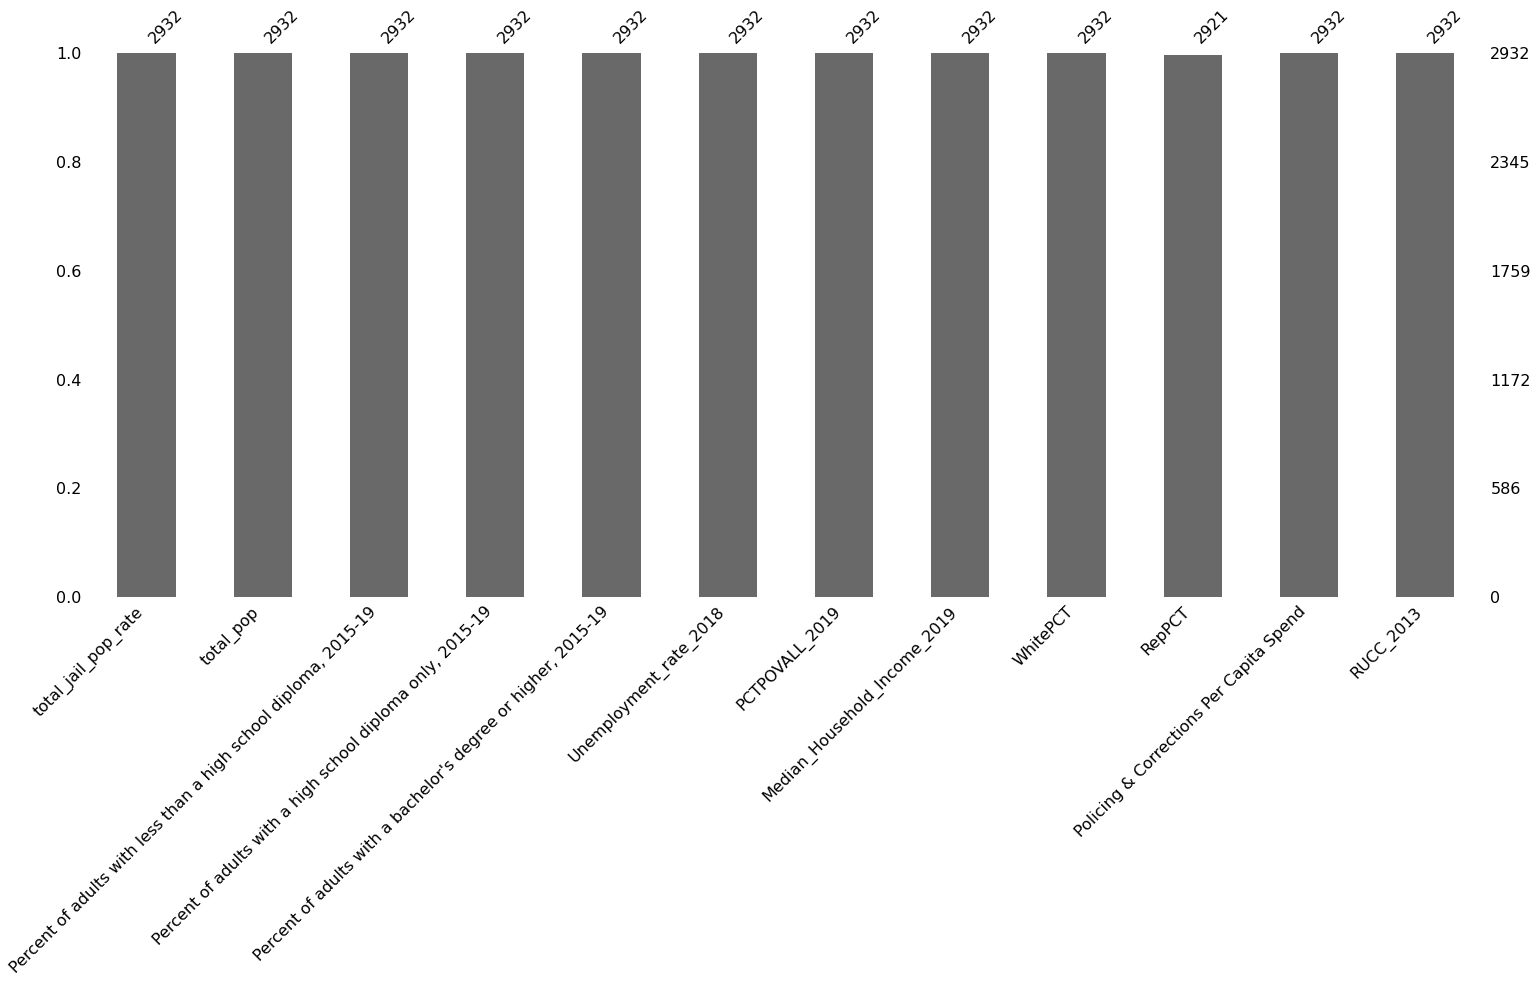

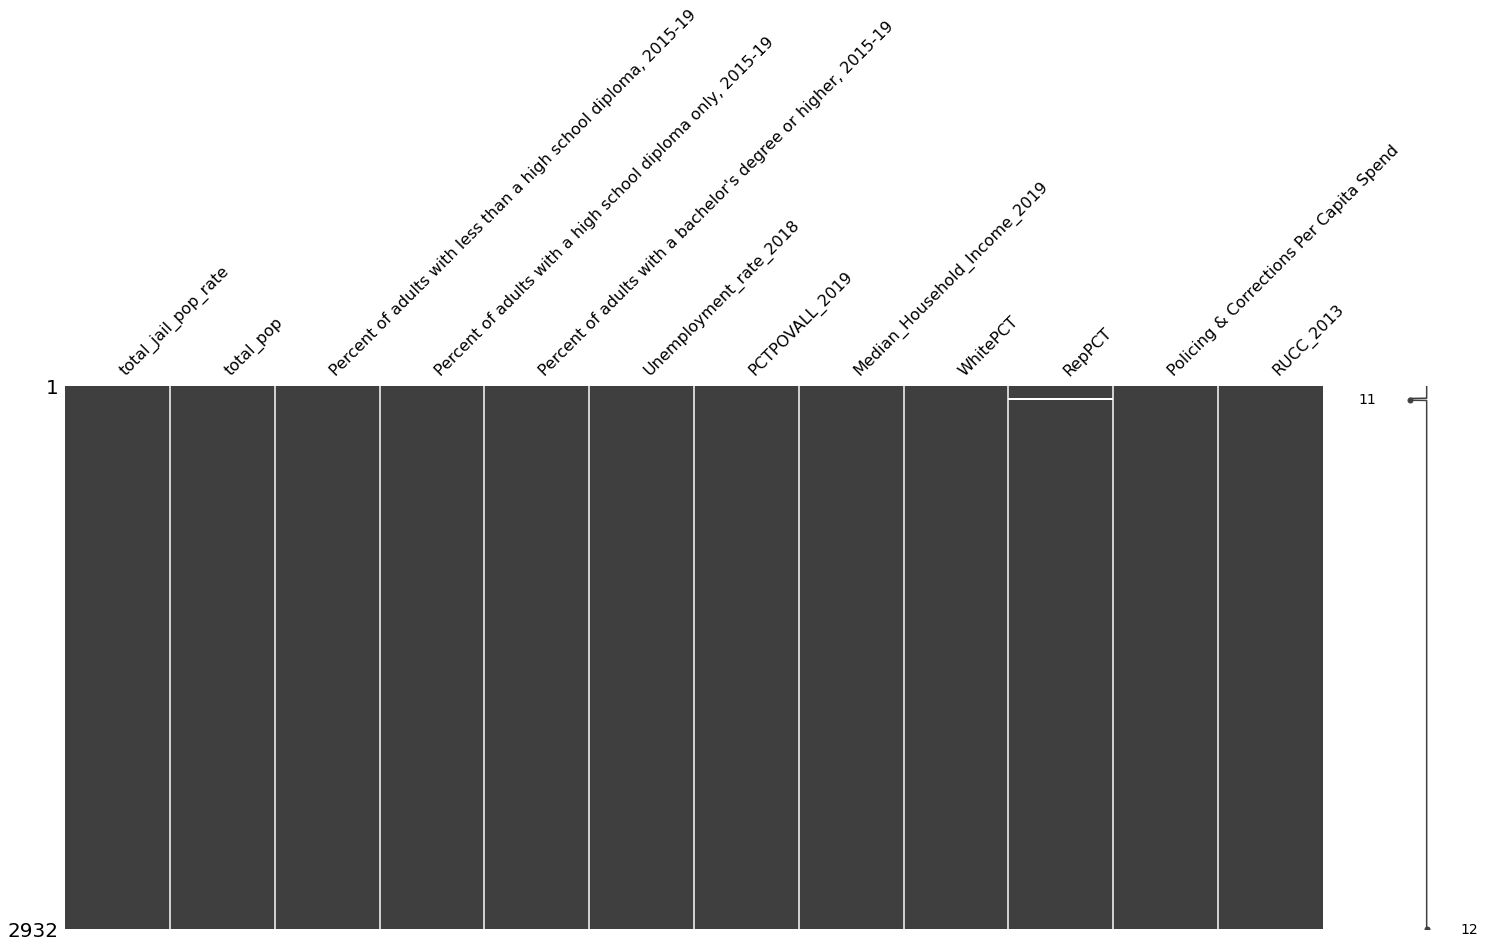

In [6]:
#getting data types 
print(pred_dat.dtypes)
#randomsample
display(pred_dat.sample(n = 20, replace = False))
#nulls by column 
print(pred_dat.isnull().sum())
#miss matrix
print(miss.bar(pred_dat))
#bar plot of missingness 
print(miss.matrix(pred_dat))

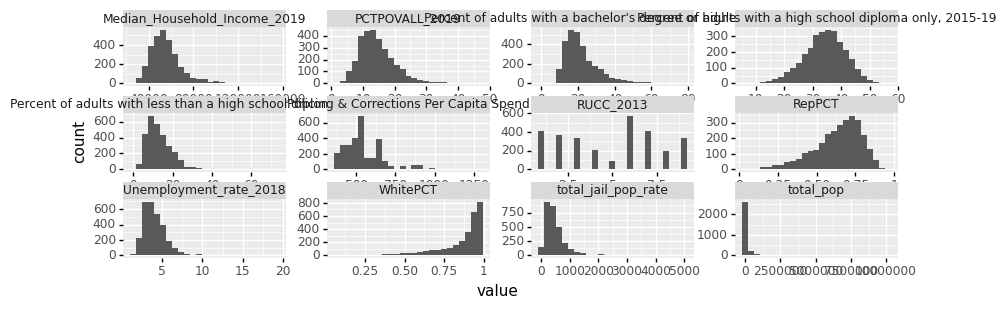

<ggplot: (8767605917034)>

In [7]:
#select_dtypes(include ="float")
#VIZING INTS
dist = pred_dat.melt()
(
    ggplot(dist ,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

In [8]:
pred_dat=pred_dat.dropna()

y = pred_dat[['total_jail_pop_rate']]
x = pred_dat.drop(columns=['total_jail_pop_rate'])
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size = .25,random_state=202011)


print(train_x.shape[0]/pred_dat.shape[0])
print(test_x.shape[0]/pred_dat.shape[0])

0.749743238616912
0.250256761383088


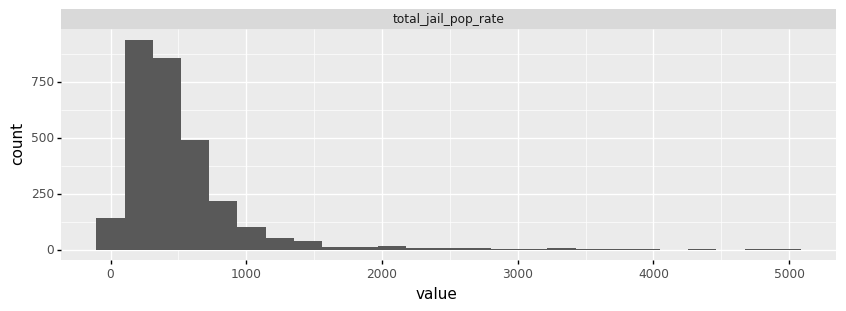

<ggplot: (8767605450358)>

In [9]:
dist = y.melt()
(
    ggplot(dist ,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

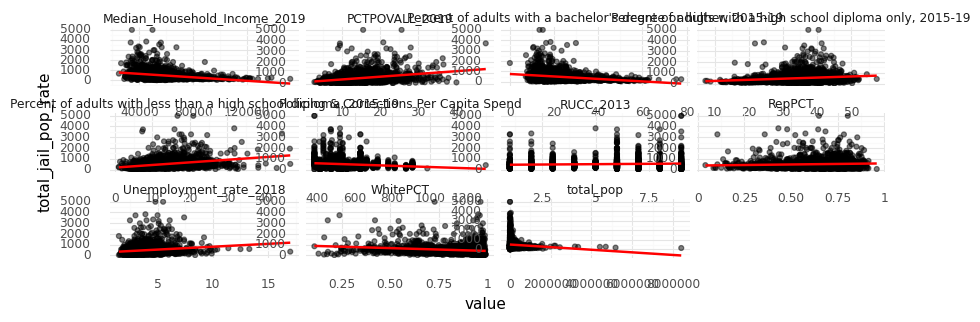

<ggplot: (8767605409669)>

In [10]:
D = train_x.copy()
D['total_jail_pop_rate'] = train_y

(
    ggplot(D.melt(id_vars=["total_jail_pop_rate"]),
           aes(x="value",y="total_jail_pop_rate"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

In [11]:

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['total_pop', 
'Percent of adults with less than a high school diploma, 2015-19' , 'Percent of adults with a high school diploma only, 2015-19',
"Percent of adults with a bachelor's degree or higher, 2015-19", 
'Unemployment_rate_2018', 'PCTPOVALL_2019', 'Median_Household_Income_2019', 'WhitePCT', 'RepPCT', 'Policing & Corrections Per Capita Spend', 'RUCC_2013'])])

# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[2,3,4],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['total_pop',
                                                                          'Percent '
                                                                          'of '
                                                                          'adults '
                                                                          'with '
                                                                          'less '
                                                                          'than '
                                                                          'a '
                                                

In [12]:
print(search.best_score_)

search.best_params_

-170269.96385201882


{'model': LinearRegression()}

In [13]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_x)
print(m.mean_squared_error(test_y,pred_y))
m.r2_score(test_y,pred_y)




232468.05013642562


0.09001311997143457

In [14]:
pred_y = DataFrame(pred_y,columns=['pred'])
pred_y = pred_y['pred'].tolist()
test_y=test_y['total_jail_pop_rate'].tolist()

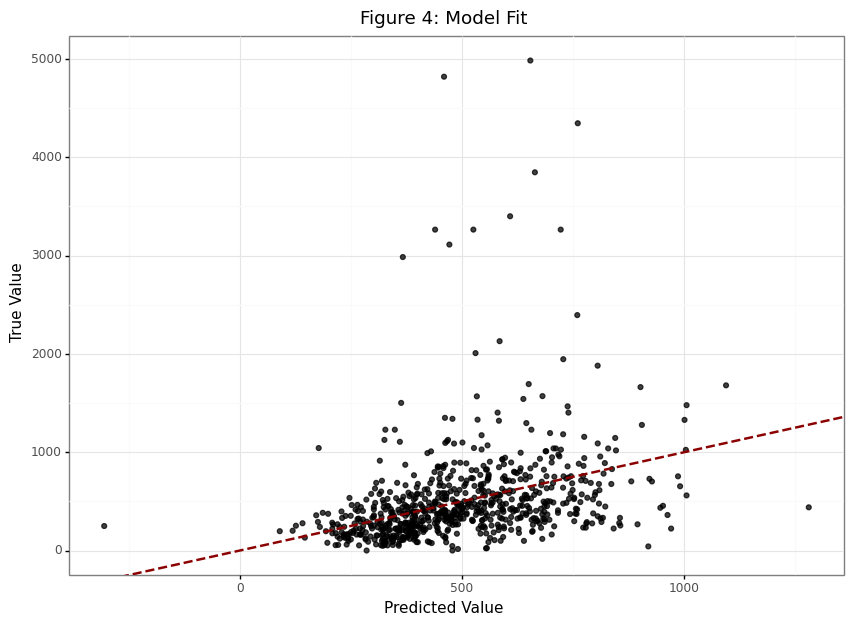

<ggplot: (8767680297301)>

In [15]:
(
    ggplot(pd.DataFrame(dict(Predicted_Value=pred_y,True_Value=test_y)),
          aes(x='Predicted_Value',y="True_Value")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7)) +
    labs(y="True Value", x="Predicted Value", title="Figure 4: Model Fit")
)

<AxesSubplot:title={'center':'Figure 1: County Level Incarcerations per 100,000'}>

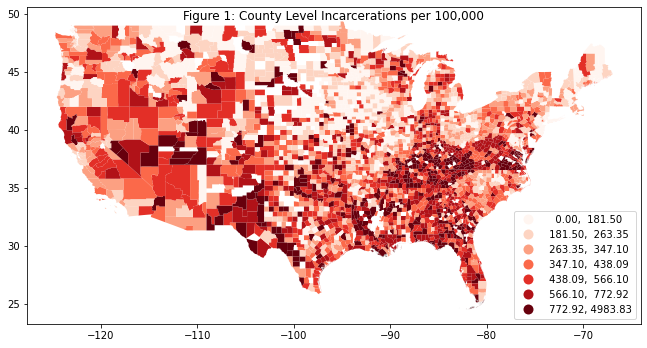

In [16]:

not_mainland = ['Alaska', 'Hawaii']
mainland_usa = countymap.query('STATE_NAME not in @not_mainland')
mainland_usa.sort_values("STATE_NAME")
fig, ax = plt.subplots(1, 1, figsize=[11,8])
plt.title("Figure 1: County Level Incarcerations per 100,000", x=.5, y=.94, fontname="DejaVu Sans"),
(mainland_usa.plot(column='total_jail_pop_rate', cmap='Reds', scheme='quantiles', k=7, 
                  legend=True, ax=ax, legend_kwds={'loc': 'lower right'}))

<AxesSubplot:title={'center':'Figure 2: Percent of County in Poverty'}>

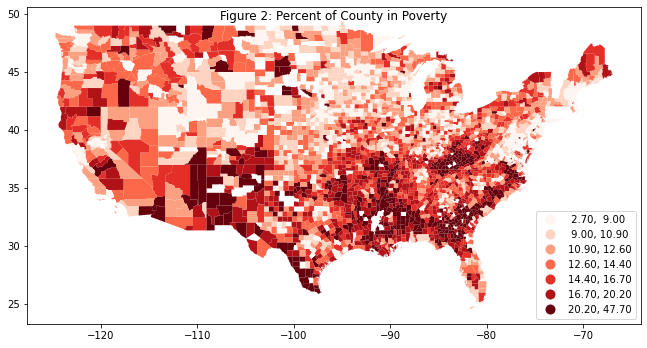

In [17]:
not_mainland = ['Alaska', 'Hawaii']
mainland_usa = countymap.query('STATE_NAME not in @not_mainland')
mainland_usa.sort_values("STATE_NAME")
fig, ax = plt.subplots(1, 1, figsize=[11,8])
plt.title("Figure 2: Percent of County in Poverty", x=.5, y=.94, fontname="DejaVu Sans"),
(mainland_usa.plot(column="PCTPOVALL_2019", cmap='Reds', scheme='quantiles', k=7, 
                  legend=True, ax=ax, legend_kwds={'loc': 'lower right'}))



<AxesSubplot:title={'center':'Figure 3: Percent of Adults with No High School Diploma'}>

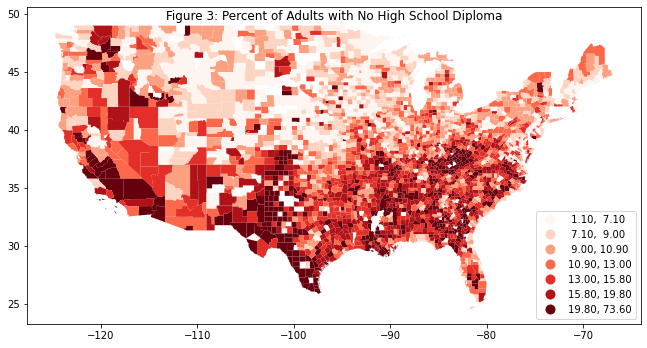

In [18]:
not_mainland = ['Alaska', 'Hawaii']
mainland_usa = countymap.query('STATE_NAME not in @not_mainland')
mainland_usa.sort_values("STATE_NAME")
fig, ax = plt.subplots(1, 1, figsize=[11,8])
plt.title("Figure 3: Percent of Adults with No High School Diploma", x=.5, y=.94, fontname="DejaVu Sans"),
(mainland_usa.plot(column='Percent of adults with less than a high school diploma, 2015-19', cmap='Reds', scheme='quantiles', k=7, 
                  legend=True, ax=ax, legend_kwds={'loc': 'lower right'}))

<AxesSubplot:title={'center':'Percent of Adults Unemployed'}>

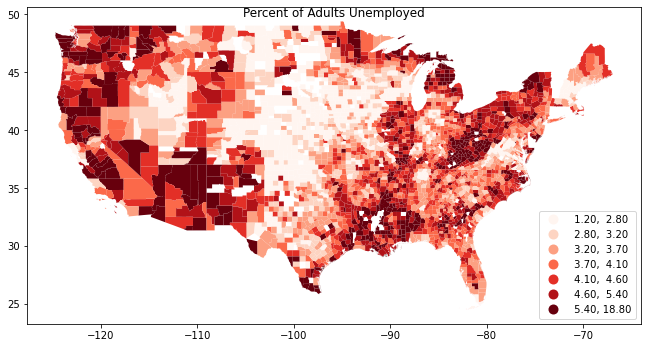

In [19]:

not_mainland = ['Alaska', 'Hawaii']
mainland_usa = countymap.query('STATE_NAME not in @not_mainland')
mainland_usa.sort_values("STATE_NAME")
fig, ax = plt.subplots(1, 1, figsize=[11,8])
plt.title("Percent of Adults Unemployed", x=.5, y=.95, fontname="DejaVu Sans"),
(mainland_usa.plot(column='Unemployment_rate_2018', cmap='Reds', scheme='quantiles', k=7, 
                  legend=True, ax=ax, legend_kwds={'loc': 'lower right'}))

<AxesSubplot:title={'center':'2016 Republican Vote share'}>

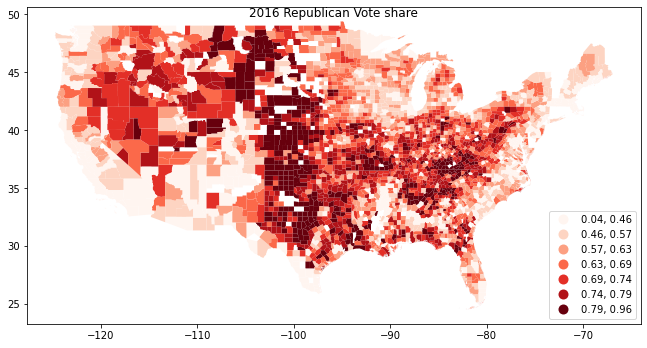

In [20]:
not_mainland = ['Alaska', 'Hawaii']
mainland_usa = countymap.query('STATE_NAME not in @not_mainland')
mainland_usa.sort_values("STATE_NAME")
fig, ax = plt.subplots(1, 1, figsize=[11,8])
plt.title("2016 Republican Vote share", x=.5, y=.95, fontname="DejaVu Sans"),
(mainland_usa.plot(column="RepPCT", cmap='Reds', scheme='quantiles', k=7, 
                  legend=True, ax=ax, legend_kwds={'loc': 'lower right'}))

In [21]:
rf_mod=search.best_estimator_
vi = permutation_importance(rf_mod,train_x,train_y,n_repeats=25)

# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_x.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

vi_dat

,variable,vi,std,low,high
0,Percent of adults with less than a high school...,0.100597,0.008137,0.084323,0.116871
1,WhitePCT,0.026550,0.005206,0.016139,0.036961
2,PCTPOVALL_2019,0.023892,0.003328,0.017235,0.030549
3,RepPCT,0.018352,0.003715,0.010922,0.025782
4,total_pop,0.008319,0.002004,0.004311,0.012326
5,Percent of adults with a bachelor's degree or ...,0.007075,0.001664,0.003747,0.010403
6,Median_Household_Income_2019,0.005860,0.001837,0.002186,0.009535
7,Percent of adults with a high school diploma o...,0.005808,0.001380,0.003047,0.008569
8,RUCC_2013,0.005416,0.001923,0.001570,0.009262
9,Policing & Corrections Per Capita Spend,0.001747,0.000984,-0.000221,0.003714


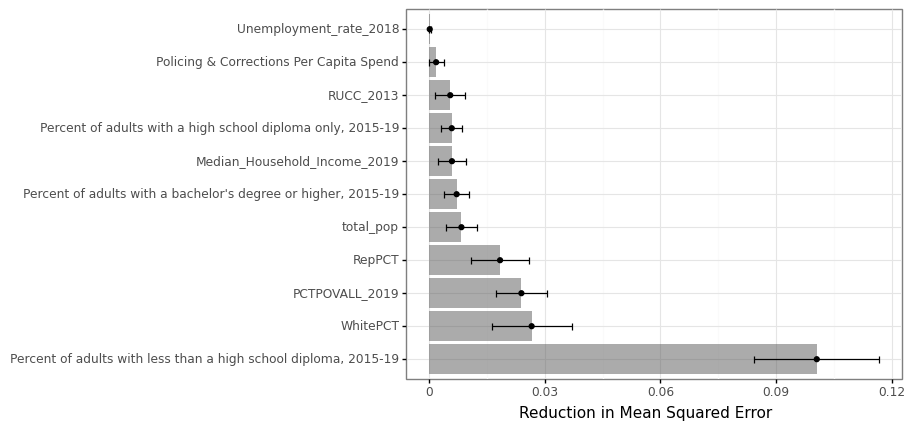

<ggplot: (8767605648556)>

In [22]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in Mean Squared Error",x="")
)

#### Lessons
- Geospatial techniques in python 
- Practice tuning machine learning models 
- Biggest obstacle so far has been cleaning data
- Learn some time series techniques, and more advanced spatial machine learning 